## CNN OVER MNIST DATASET USING PYTORCH

We involve kernel to extract the features. 
There are diffrent kernels called laplace, gaussian, etc..
Translational invariance : 
    this is the main theory for the kernels. the more filters we have, we can improve the nn,
    conbining the feature maps gives the depth of the features.
    here, in this notebook, we can work with depth 1 images of MNIST. if RGB, it is 3 depths with different channels (3d)

Any kind of nn, must contain non linearity, since many real world problem, being non linear. Convolution being a linear function here, 
Relu introduces the nonlinearity. But, we can also use Sigmoid and tanh too. But, Relu performs better in many situation. As, the Sigmoid or tanh are predisposed to vanishing gradient problems.
Because, in case of sigmoid, the gradient is very less and vanishing gradient effects here. Hence, the issue can be fixed by using rectified linear unit -Relu. (Look at their graphs for more info)

Pooling layer:
    The pooling layer reduces the size of the feature map by shrink the image therefore, reducing the computational complexity but retains the features of the image and parameters and also the overfitting
    there are max, sum. etc. 
    Max pooling:
        max value of the neighbors specified (stride) in the kernel of pool. The max value corresponds to the prevalant part of the iamge part on which the rectangle kernel over which it is being hovered over
        Hence, we keep the window of pooling very lower size by keeping in mind the destructive nature of the Pooling window

Fully Connected Layers:
    The feature maps obtained at the end of the multiple Convolution and Pooling layers, Fully connected layers  (Perceptron) intake the grayscale input of the feature maps.
    They use softmax or sigmoid as per requirement to predict the probaility of the classes.
    
Drop out layer:
To put the generalization into the model, while inbetween the learning, the perceptrons where the frequently gives the bad performance in each of the epoches are being dropped. Hence, we can use this to induce generalizations to reduce the chance of the overfitting by the Model. 

Conventionally, only one drop out layer is used to improve the performance of the model. Moreover, the dropout layer is used inbetwenn the layers  with the most number of inputs. Here, in this case, the FCNN layers has the most number  of inputs. Hence, the Dropout layer  is being used in between them.

Hyper parameter tuning:
    Modifications to be worried about:
        1. optimizer Learning rate of Adam. 
        2. adding more Conv Layers to extract more features. 
        relatively common architechture in defining the CNN layers is each layer doubles the depth of the output of the preceeding layer. 
        3. Smaller Kernel Size. As the larger  kernel means more parameters higher level of expressive level inturn overfitting. 
        4. include padding for edge preserving

In [1]:
import torch
from torchvision import datasets, transforms ##contains transformations to apply on these images before supplying to the nn
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

## Data Augmentation:
retransforming data  image into multiple images either by turning them or applying filters on them to increase the size of the dataset to increase the accuracy. This can be done if we cant fit the learning rate and also to improve the accuracy.

Inside transform, we use it.

we add here 4 transformations.
Flip, rotate, Affine (preserves st lines, etc with objects) ,  Color Jitter with brightness specified (relatively low brightness)

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10), #angle
                               transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),#params= rotation= as we've  already  set 10, so set 0 here, shear level, zoom 
                               transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))#here the first tuple, to normalize all channel with means of, second is SD
                               ])## ToTensor converts the image to the tensor and characterizes the image as


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))#here the first tuple, to normalize all channel with means of, second is SD
                               ])## ToTensor converts the image to the tensor and characterizes the image as
                                    ##Channel (C), Height (H), Width(W)
    ## using the values -1, 1 reduces the skewness of the data, hence we apply the normalizations

training_dataset = datasets.CIFAR10(root='./', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy() #first dim= color, second= width, third =height, we know that in MNIST= it is (1, 28, 28)
#but, to plot our image, we need (28, 28, 1). So, Transform it.
    image= image.transpose(1, 2, 0) #swap axis 0 to 1 and 1 to 2 and 2 to 0
#normalizaion = Z= (x-mean)/SD. So, we do this:
    
    image =image*np.array((0.5, 0.5, 0.5))+ np.array((0.5, 0.5, 0.5))
    image=image.clip(0, 1) #to ensure the values are in betn 0 and 1
    return image

In [5]:
classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse', 'ship', 'truck']

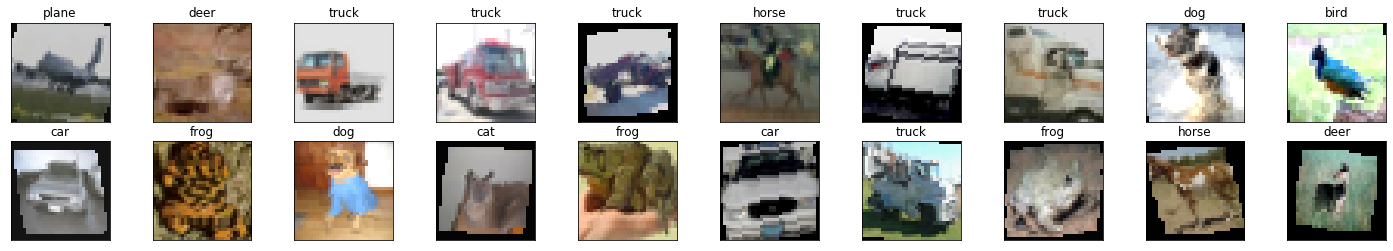

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()#grabs first batch of training data
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title(classes[labels[idx].item()])

### LeNet Model

####here, we use the LENET Model here, we use 2 Conv layers and pooling layers inbtn and 2 fully connected layers later. 

##### CONV2d Params:
        > 1. input channels: The input is the RGB image already hence 3 channel.
        
        > 2. no of feature maps
        
        > 3. kernel Size
        
        > 4. stride Size
##### Linear fc params: 
         > 1. input size: The input size to the Conv layer in the beginning is 32*32. due to 3 sized kernel and padding true, the next feature map contains 32*32 sized inputs to first pooling layer. Next, the feature map size reduced to 16*16 by the first Pooling layer with the window of size 2*2.the second layer, has the input size of 16*16 which is further reduced to 8*8 and fed into second layer. Final layer  output is 4*4, with 64 depths as indicated above and  this is the input to the first fully connected network
         
         > 2. Output size
##### Dropout params:
        only one drop out layer can be used in a nn for high perf  normally. 
        > 1. Dropout rate= i.e. the probability of the given perceptron to be dropped out. (0.5 is recommended always)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3, 16, 3, 1, padding=1) 
        self.conv2=nn.Conv2d(16, 32, 3, 1, padding=1)# same as above
        self.conv3=nn.Conv2d(32, 64, 3, 1, padding=1)# additional added layer

        self.fc1=nn.Linear(4*4*64, 500)
        self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(500, 10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x, 2, 2)#params: input, window size and stride size
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x, 2, 2)
        x=F.relu(self.conv3(x))
        x=F.max_pool2d(x, 2, 2)
        x=x.view(-1, 4*4*64) # we know the no. of rows to be inputted and let the  ravel option select the no. Of columns. Now, we need to flatten this because the fully connected network needs the flattened inputs
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=self.fc2(x)
        return x     

In [8]:
model= LeNet().to(device) #to  run on GPU
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.002)

In [10]:
#edited  after copying the old MNIST code here...
epochs=12
running_loss_history=[]
running_corrects_history=[]
val_running_loss_history=[]
val_running_corrects_history=[]


for e in range(epochs):
    running_loss=0.0
    running_corrects=0.0
    val_running_loss=0.0
    val_running_corrects=0.0

    for inputs, labels in training_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
#         inputs=inputs.view(inputs.shape[0], -1) No need to flatten as we're passing them to CNN first instead of FCNN
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds=torch.max(outputs, 1) ## here if the output is [2, 1, 0.1, ..... 10items], then the max of it indicates that the item belongs to that class            
        running_loss+=loss.item()#add up to batch iteration
        running_corrects+=torch.sum(preds==labels.data)
        
    ## after every epoch, validate using test set
    else:
        with torch.no_grad():#sets requires_grad flag to false as it is not needed here and saves the memory.
            for val_inputs, val_labels in validation_loader:
                val_inputs=val_inputs.to(device)
                val_labels=val_labels.to(device)
#                 val_inputs=val_inputs.view(val_inputs.shape[0], -1)
                val_outputs=model(val_inputs)
                val_loss=criterion(val_outputs, val_labels)                
                _, val_preds=torch.max(val_outputs, 1) ## here if the output is [2, 1, 0.1, ..... 10items], then the max of it indicates that the item belongs to that class            
                val_running_loss+=val_loss.item()#add up to batch iteration
                val_running_corrects+=torch.sum(val_preds==val_labels.data)
        
        epoch_loss=(running_loss)/len(training_loader)
        epoch_acc= (running_corrects.float())/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        print("EPOCH: ", e+1)
        print('training loss: {:.4f}, Train Accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        
        val_epoch_loss=(val_running_loss)/len(validation_loader)
        val_epoch_acc= (val_running_corrects.float())/len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Validation loss: {:.4f}, Validation Accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

EPOCH:  1
training loss: 1.6449, Train Accuracy 39.4180
Validation loss: 1.3359, Validation Accuracy 51.3600
EPOCH:  2
training loss: 1.3323, Train Accuracy 51.8420
Validation loss: 1.1637, Validation Accuracy 58.3000
EPOCH:  3
training loss: 1.1990, Train Accuracy 57.0220
Validation loss: 1.0490, Validation Accuracy 62.6400
EPOCH:  4
training loss: 1.1263, Train Accuracy 60.0500
Validation loss: 1.0428, Validation Accuracy 62.9300
EPOCH:  5
training loss: 1.0630, Train Accuracy 62.3480
Validation loss: 0.9762, Validation Accuracy 65.8000
EPOCH:  6
training loss: 1.0313, Train Accuracy 63.6360
Validation loss: 0.9309, Validation Accuracy 67.5600
EPOCH:  7
training loss: 0.9923, Train Accuracy 65.0000
Validation loss: 0.9216, Validation Accuracy 67.9800
EPOCH:  8
training loss: 0.9762, Train Accuracy 65.9660
Validation loss: 0.9091, Validation Accuracy 68.8500
EPOCH:  9
training loss: 0.9568, Train Accuracy 66.4660
Validation loss: 0.8723, Validation Accuracy 70.3100
EPOCH:  10
training

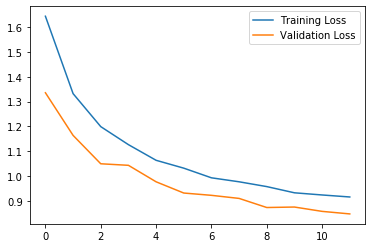

In [11]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

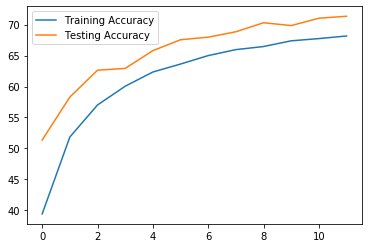

In [12]:
plt.plot(running_corrects_history, label="Training Accuracy")
plt.plot(val_running_corrects_history, label="Testing Accuracy")
plt.legend()

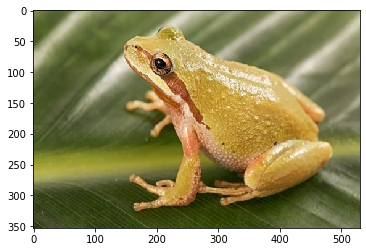

In [17]:
#testing using the images in the web
import requests
from PIL import Image
import PIL.ImageOps
url='http://www.aquariumofpacific.org/images/made/images/uploads/20170502_AOPfrog_pacifictree_5123_530_353_80auto_s.jpg'
response=requests.get(url, stream=True)
img=Image.open(response.raw)
plt.imshow(img)

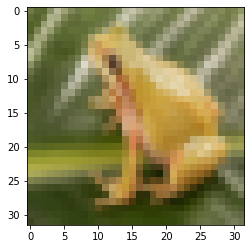

In [18]:
#preprocess it 
img=transform(img) #from the fun declared earlier in the beginning
plt.imshow(im_convert(img))

In [19]:
#now, feed it to the  nn.
img=img.to(device).unsqueeze(0)
# image=img[0].unsqueeze(0).unsqueeze(0)# to add the extra dim
output=model(img)
_, pred=torch.max(output, 1)
print(classes[pred.item()])

frog


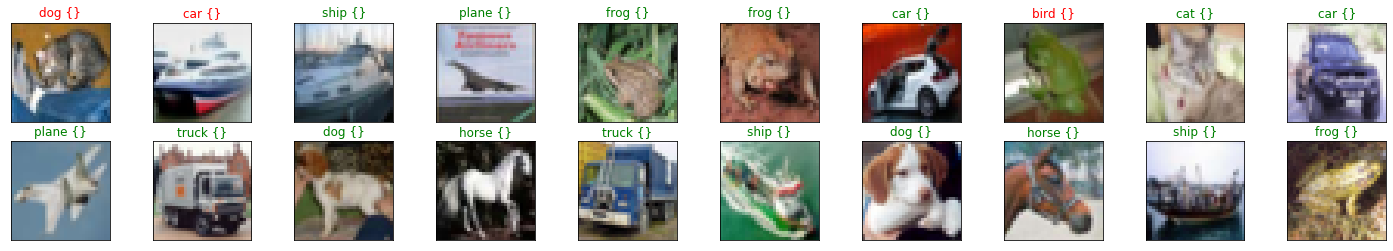

In [20]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()#grabs first batch of training data

images_=images.to(device)
labels=labels.to(device)

output=model(images_)
_, preds=torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title("{} {{}}".format(str(classes[preds[idx].item()]), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))